🟦 STEP 1 — Import libraries

In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

🟦 STEP 2 — Load the two CSV files

In [3]:
from google.colab import drive
drive.mount('/content/drive')
train = pd.read_csv("/content/drive/MyDrive/content/ML_DL/Dataset/training_cleaned.csv")
test  = pd.read_csv("/content/drive/MyDrive/content/ML_DL/Dataset/test_cleaned.csv")

Mounted at /content/drive


🟦 STEP 3 — Make sure columns match & combine them

In [4]:
# (optional but safer) keep only common columns
common_cols = [c for c in train.columns if c in test.columns]
train = train[common_cols]
test  = test[common_cols]

# merge into one dataframe
df_all = pd.concat([train, test], ignore_index=True)

🟦 STEP 4 — Remove label columns (because K-means is unsupervised)

Identify and drop the label columns (change names if yours are slightly different):

In [5]:
df_unsup = df_all.drop(columns=["category"])

🟦 STEP 5 — Keep only numeric columns

K-means needs numeric data only:

In [6]:
df_unsup = df_unsup.select_dtypes(include=["number"])

🟦 STEP 6 — Handle missing values

Simple choice: remove rows with NaN (you can mention this in the report):

In [7]:
df_unsup = df_unsup.dropna()

🟦 STEP 7 — Selecting a randoom amount of samples (lignes)
 Even the collab processing power doesn't support calculating the Silhouette score for +3M samples

In [8]:
df_all.shape


(3668522, 14)

In [9]:
# Take a sample of 200,000 rows
df_sample = df_unsup.sample(n=200000, random_state=42)

print(df_sample.shape)


(200000, 12)


🟦 STEP 8 — Scale the features

Very important for K-means:

In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_sample = scaler.fit_transform(df_sample.values)


🟦 STEP 9 — Try several k values and compute Silhouette score

You test k from 2 to 10 (for example):

In [11]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

sil_scores = {}

for k in range(2, 11):
    print(f"Testing k = {k} ...")
    kmeans = KMeans(
        n_clusters=k,
        random_state=42,
        n_init=3   # faster than default 10
    )
    labels = kmeans.fit_predict(X_sample)
    score = silhouette_score(X_sample, labels)
    sil_scores[k] = score
    print(f"k = {k}, Silhouette = {score:.4f}")


Testing k = 2 ...
k = 2, Silhouette = 0.3414
Testing k = 3 ...
k = 3, Silhouette = 0.2915
Testing k = 4 ...
k = 4, Silhouette = 0.2919
Testing k = 5 ...
k = 5, Silhouette = 0.3067
Testing k = 6 ...
k = 6, Silhouette = 0.3167
Testing k = 7 ...
k = 7, Silhouette = 0.2626
Testing k = 8 ...
k = 8, Silhouette = 0.2631
Testing k = 9 ...
k = 9, Silhouette = 0.2300
Testing k = 10 ...
k = 10, Silhouette = 0.2406


/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

🟦 STEP 9 — Choose the best k and fit final K-means

In [12]:
best_k = max(sil_scores, key=sil_scores.get)

kmeans_final = KMeans(n_clusters=best_k, random_state=42, n_init=10)
#final_labels = kmeans_final.fit_predict(X)
final_labels = kmeans_final.fit_predict(X_sample)

🟦 STEP 10 — (Optional but useful) Attach cluster labels to the original data

In [13]:
df_sample_with_clusters = df_sample.copy()
df_sample_with_clusters["cluster"] = final_labels


In [14]:
print(df_sample_with_clusters["cluster"].value_counts())


cluster
1    144348
0     55652
Name: count, dtype: int64


In [15]:
import joblib

# 1. Save the scaler (the last one you defined, used with X_full and k=8)
joblib.dump(scaler, "kmeans_scaler1.pkl")
print("Saved scaler -> kmeans_scaler1.pkl")

# 2. Save the K-means model from the first experiment (k chosen by silhouette, k=2 on sample)
joblib.dump(kmeans_final, "kmeans_k2_model.pkl")
print("Saved K-means model (k=2) -> kmeans_k2_model.pkl")

Saved scaler -> kmeans_scaler1.pkl
Saved K-means model (k=2) -> kmeans_k2_model.pkl


In [ ]:
true_labels_sample = df_all.loc[df_sample_with_clusters.index, "category"]
df_sample_with_clusters["category"] = true_labels_sample.values


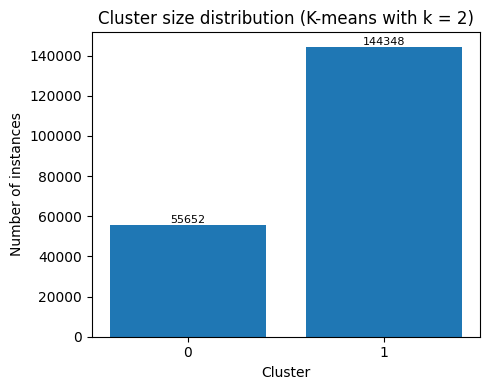

In [16]:
import matplotlib.pyplot as plt

# You can get this directly from the DataFrame if you still have it:
cluster_counts = df_sample_with_clusters["cluster"].value_counts().sort_index()

# Or manually:
# import pandas as pd
# cluster_counts = pd.Series({0: 55652, 1: 144348})

plt.figure(figsize=(5, 4))
plt.bar(cluster_counts.index.astype(str), cluster_counts.values)
plt.xlabel("Cluster")
plt.ylabel("Number of instances")
plt.title("Cluster size distribution (K-means with k = 2)")
for idx, value in enumerate(cluster_counts.values):
    plt.text(idx, value, str(value), ha="center", va="bottom", fontsize=8)
plt.tight_layout()
plt.savefig("cluster_distribution_k2.png", dpi=300)
plt.show()



**FIXING k TO 8**

In [17]:
from sklearn.preprocessing import StandardScaler

df_unsup = df_all.drop(columns=["category"])
df_unsup = df_unsup.drop(columns=["pkSeqID"], errors='ignore')
df_unsup = df_unsup.select_dtypes(include=["number"])
df_unsup = df_unsup.dropna()

scaler = StandardScaler()
X_full = scaler.fit_transform(df_unsup.values)


In [18]:
from sklearn.cluster import KMeans

kmeans_k8 = KMeans(
    n_clusters=8,
    random_state=42,
    n_init=5   # less repeated runs → much faster
)

# THIS WILL BE SLOW BUT IT WILL RUN
full_labels_k8 = kmeans_k8.fit_predict(X_full)


In [19]:
df_all_clusters_k8 = df_unsup.copy()
df_all_clusters_k8["cluster"] = full_labels_k8


In [20]:
print(df_all_clusters_k8["cluster"].value_counts().sort_index())


cluster
0    1304443
1     192817
2    1125212
3     804358
4          4
5          9
6     222495
7      19184
Name: count, dtype: int64


In [21]:
from sklearn.metrics import silhouette_score

df_sample_eval = df_unsup.sample(n=500000, random_state=42)
X_sample_eval = scaler.transform(df_sample_eval)

sample_labels = kmeans_k8.predict(X_sample_eval)

sil_k8 = silhouette_score(X_sample_eval, sample_labels)
print("Silhouette for k=8 on sample:", sil_k8)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Silhouette for k=8 on sample: 0.35452749059686584


In [22]:
import joblib

# 1. Save the scaler (the last one you defined, used with X_full and k=8)
joblib.dump(scaler, "kmeans_scaler_k8.pkl")
print("Saved scaler -> kmeans_scaler_k8.pkl")

# 2. Save the K-means model from the second experiment (k=8 on full dataset)
joblib.dump(kmeans_k8, "kmeans_k8_model.pkl")
print("Saved K-means model (k=8) -> kmeans_k8_model.pkl")


Saved scaler -> kmeans_scaler_k8.pkl
Saved K-means model (k=8) -> kmeans_k8_model.pkl
